1. DATA PROCESSING AND CLEANING

Install libraries

In [ ]:
"""install required libraries, geopandas (for geospatial data handling)
                              pandas (for CSV and general data handling)
                              pyshp (to work with SHP, DBF, SHX files)
                              fiona (for geospatial file reading)
                              xmltodict (for easier XML parsing)"""
!pip install geopandas pandas pyshp fiona xmltodict

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.6/56.6 kB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.3/17.3 MB 28.4 MB/s eta 0:00:00


Load and merge different file formats (geopandas for GeoJSON, Shapefiles, KML; pandas for CSV).

In [ ]:
#Load CSV File
import pandas as pd
df_csv = pd.read_csv("/content/drive/MyDrive/int 375/CRIME INCIDENTS DOT FILES/Crime_Incidents_in_2025.csv")

#Load XML File
import xml.etree.ElementTree as ET
tree = ET.parse("/content/drive/MyDrive/int 375/CRIME INCIDENTS DOT FILES/Crime_Incidents_in_2025.xml")
root = tree.getroot()

#Load Shapefile (SHP, SHX, DBF)
import geopandas as gpd
df_shp = gpd.read_file("/content/drive/MyDrive/int 375/CRIME INCIDENTS DOT FILES/Crime_Incidents_in_2025.shp")

#Load CPG, DBF, PRJ Separately (if needed)
import shapefile
sf = shapefile.Reader("/content/drive/MyDrive/int 375/CRIME INCIDENTS DOT FILES/Crime_Incidents_in_2025.shp")  # Loads .shp, .shx, .dbf together
records = sf.records()
fields = sf.fields

#To read PRJ (Projection file):
with open("/content/drive/MyDrive/int 375/CRIME INCIDENTS DOT FILES/Crime_Incidents_in_2025.prj") as f:
    prj_data = f.read()

#Load KML File
df_kml = gpd.read_file("/content/drive/MyDrive/int 375/CRIME INCIDENTS DOT FILES/Crime_Incidents_in_2025.kml")

#Load GeoJSON File
df_geojson = gpd.read_file("/content/drive/MyDrive/int 375/CRIME INCIDENTS DOT FILES/Crime_Incidents_in_2025.geojson")

Check for missing values, duplicate entries, or incorrect coordinates.

In [ ]:
# prompt: Check for missing values, duplicate entries, or incorrect coordinates.

import pandas as pd
import numpy as np

# Assuming df_csv, df_shp, df_kml, and df_geojson are already loaded as in the previous code

def check_data_quality(df, data_source):
    """
    Checks for missing values, duplicates, and invalid coordinates in a DataFrame.

    Args:
        df: The input DataFrame.
        data_source: A string indicating the data source (e.g., "CSV", "Shapefile").
    """
    print(f"Data Quality Report for {data_source}:")

    # Check for missing values
    missing_values = df.isnull().sum()
    print("\nMissing Values:")
    print(missing_values)

    # Check for duplicate entries
    duplicate_rows = df.duplicated().sum()
    print(f"\nNumber of duplicate rows: {duplicate_rows}")
    if duplicate_rows > 0:
      print("Duplicate Rows:")
      print(df[df.duplicated()])


    # Check for incorrect coordinates (if applicable)
    if "geometry" in df.columns and isinstance(df, gpd.GeoDataFrame):
        # Check for invalid geometries
        invalid_geometries = df[~df.geometry.is_valid]
        print(f"\nNumber of invalid geometries: {len(invalid_geometries)}")
        if not invalid_geometries.empty:
          print("Invalid Geometries:")
          print(invalid_geometries)

        # Check for empty geometries
        empty_geometries = df[df.geometry.is_empty]
        print(f"\nNumber of empty geometries: {len(empty_geometries)}")
        if not empty_geometries.empty:
          print("Empty Geometries:")
          print(empty_geometries)


        # Check for coordinates outside a reasonable range (example: latitude between -90 and 90)

        if 'latitude' in df.columns:
          out_of_range_lat = df[(df['latitude'] < -90) | (df['latitude'] > 90)]
          if not out_of_range_lat.empty:
              print(f"\nLatitude values out of range (-90 to 90):")
              print(out_of_range_lat)

        if 'longitude' in df.columns:
          out_of_range_lon = df[(df['longitude'] < -180) | (df['longitude'] > 180)]
          if not out_of_range_lon.empty:
              print(f"\nLongitude values out of range (-180 to 180):")
              print(out_of_range_lon)


Convert all datasets to the same Coordinate Reference System (CRS) (e.g., WGS84, EPSG:4326).

In [ ]:
#Convert all datasets to the same Coordinate Reference System (CRS) (e.g., WGS84, EPSG:4326).
import pandas as pd
import numpy as np
import geopandas as gpd

# Assuming df_shp, df_kml, and df_geojson are already loaded as GeoDataFrames

def standardize_crs(df, data_source, target_crs="EPSG:4326"):
    """
    Converts the dataset to a common Coordinate Reference System (CRS).

    Args:
        df: The input DataFrame or GeoDataFrame.
        data_source: A string indicating the data source (e.g., "Shapefile").
        target_crs: The target CRS to convert to (default is EPSG:4326).

    Returns:
        The transformed DataFrame or GeoDataFrame.
    """
    if isinstance(df, gpd.GeoDataFrame):
        if df.crs is None:
            print(f"Warning: {data_source} has no CRS. Assigning EPSG:4326.")
            df.set_crs(target_crs, inplace=True)
        elif df.crs.to_string() != target_crs:
            print(f"Converting {data_source} to {target_crs}...")
            df = df.to_crs(target_crs)
        else:
            print(f"{data_source} is already in {target_crs}.")

    return df

# Convert all spatial datasets to EPSG:4326
df_shp = standardize_crs(df_shp, "Shapefile")
df_kml = standardize_crs(df_kml, "KML")
df_geojson = standardize_crs(df_geojson, "GeoJSON")


Converting Shapefile to EPSG:4326...
KML is already in EPSG:4326.
GeoJSON is already in EPSG:4326.


In [ ]:
#Check if conversion was successful
print("Shapefile CRS:", df_shp.crs)
print("KML CRS:", df_kml.crs)
print("GeoJSON CRS:", df_geojson.crs)
#No need to convert the latitude and longitude column in the csv files because it is  already in EPSG:4326 format

Shapefile CRS: EPSG:4326
KML CRS: EPSG:4326
GeoJSON CRS: EPSG:4326


2. CRIME HOTSPOT DETECTION (SPATIAL ANALYSIS)

In [ ]:
!pip install contextily

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 31.1 MB/s eta 0:00:00


In [ ]:
!pip install geopandas contextily osmnx pandas matplotlib seaborn scikit-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.9/99.9 kB 1.8 MB/s eta 0:00:00


In [ ]:
!pip install libpysal pointpats

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.8/2.8 MB 24.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.2/59.2 kB 4.5 MB/s eta 0:00:00


<ipython-input-15-5e43b84f0193>:64: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  plt.legend()
<ipython-input-15-5e43b84f0193>:64: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


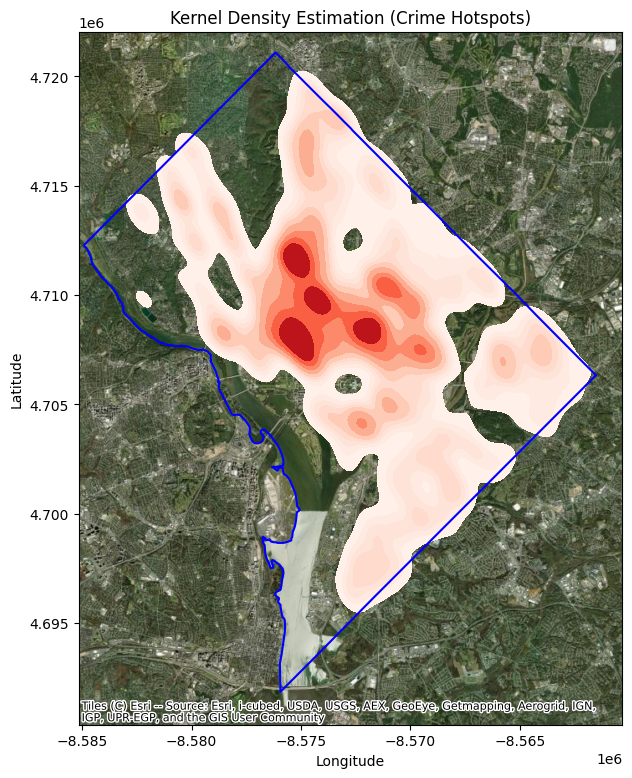

<ipython-input-15-5e43b84f0193>:94: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  plt.legend(title="Cluster")


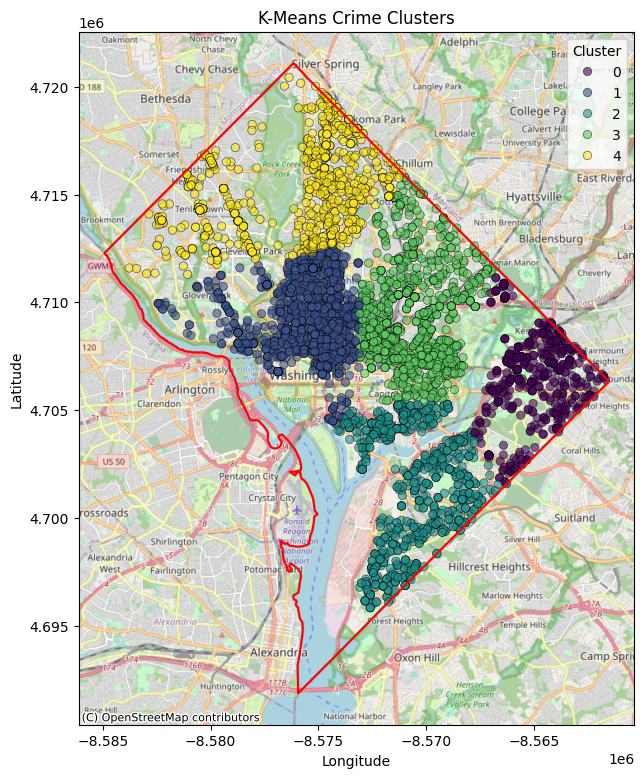

<ipython-input-15-5e43b84f0193>:124: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  plt.legend(title="Cluster")


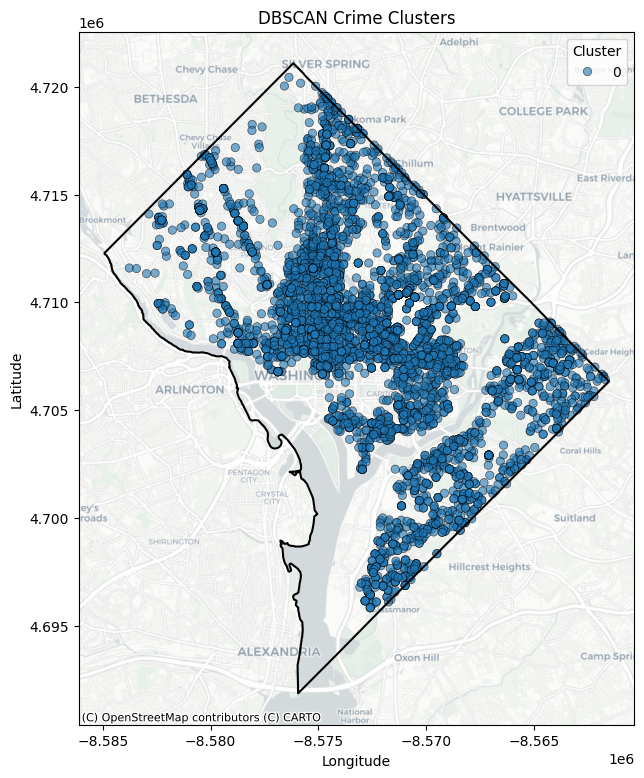

In [ ]:
# ===============================
# 📌 STEP 1: IMPORT LIBRARIES
# ===============================
import pandas as pd
import geopandas as gpd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import contextily as ctx  # Adds real map backgrounds
import osmnx as ox  # Extracts city boundary from OpenStreetMap
from sklearn.cluster import KMeans, DBSCAN
from pointpats import k


# ===============================
# 📂 STEP 2: LOAD & CLEAN DATA
# ===============================

# Load dataset
file_path = "/content/drive/MyDrive/int 375/CRIME INCIDENTS DOT FILES/Crime_Incidents_in_2025.csv"
df = pd.read_csv(file_path)

# Ensure column names are uppercase
df = df.rename(columns=str.upper)

# Remove rows with missing coordinates
df = df.dropna(subset=['LATITUDE', 'LONGITUDE'])

# Convert to GeoDataFrame
gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df['LONGITUDE'], df['LATITUDE']), crs="EPSG:4326")
gdf = gdf.to_crs(epsg=3857)  # Convert to Web Mercator for map backgrounds

# ===============================
# 🗺️ STEP 3: GET CITY BOUNDARY FROM OPENSTREETMAP
# ===============================

# 🔹 Change this to the name of your city
city_name = "Washington, D.C., USA"

# Get the city boundary from OpenStreetMap
city_boundary = ox.geocode_to_gdf(city_name)

# Convert city boundary to Web Mercator
city_boundary = city_boundary.to_crs(epsg=3857)

# ===============================
# 🔥 STEP 4: KDE HEATMAP (SATELLITE BACKGROUND)
# ===============================
def plot_kde_with_satellite(gdf, city_boundary):
    fig, ax = plt.subplots(figsize=(15, 9))

    # 🔥 KDE Density Plot
    sns.kdeplot(x=gdf.geometry.x, y=gdf.geometry.y, cmap='Reds', fill=True, bw_adjust=0.5, ax=ax)

    # ⚫ Overlay city boundary
    city_boundary.plot(ax=ax, facecolor="none", edgecolor="blue", linewidth=1.5, label="City Boundary")

    # 🗺️ Add satellite map background
    ctx.add_basemap(ax, source=ctx.providers.Esri.WorldImagery, zoom=12)

    ax.set_title("Kernel Density Estimation (Crime Hotspots)")
    ax.set_xlabel("Longitude")
    ax.set_ylabel("Latitude")
    plt.legend()
    plt.show()

plot_kde_with_satellite(gdf, city_boundary)

# ===============================
# 🔥 STEP 5: K-MEANS CLUSTERING (STREET MAP)
# ===============================
def kmeans_clustering_with_streetmap(gdf, city_boundary, n_clusters=5):
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
    gdf['kmeans_cluster'] = kmeans.fit_predict(gdf[['LONGITUDE', 'LATITUDE']])

    fig, ax = plt.subplots(figsize=(15, 9))

    # 🔹 Scatter plot with cluster colors
    sns.scatterplot(
        x=gdf.geometry.x, y=gdf.geometry.y,
        hue=gdf['kmeans_cluster'], palette='viridis', alpha=0.6,
        edgecolor='black', linewidth=0.5, ax=ax
    )

    # ⚫ Overlay city boundary
    city_boundary.plot(ax=ax, facecolor="none", edgecolor="red", linewidth=1.5, label="City Boundary")

    # 🗺️ Add street map background
    ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik, zoom=12)

    ax.set_title("K-Means Crime Clusters")
    ax.set_xlabel("Longitude")
    ax.set_ylabel("Latitude")
    plt.legend(title="Cluster")
    plt.show()

kmeans_clustering_with_streetmap(gdf, city_boundary)

# ===============================
# 🔥 STEP 6: DBSCAN CLUSTERING (LIGHT MAP)
# ===============================
def dbscan_clustering_with_lightmap(gdf, city_boundary, eps=0.01, min_samples=5):
    db = DBSCAN(eps=eps, min_samples=min_samples, metric='haversine').fit(np.radians(gdf[['LATITUDE', 'LONGITUDE']]))
    gdf['dbscan_cluster'] = db.labels_

    fig, ax = plt.subplots(figsize=(15, 9))

    # 🔹 Scatter plot with clusters
    sns.scatterplot(
        x=gdf.geometry.x, y=gdf.geometry.y,
        hue=gdf['dbscan_cluster'], palette='tab10', alpha=0.6,
        edgecolor='black', linewidth=0.5, ax=ax
    )

    # ⚫ Overlay city boundary
    city_boundary.plot(ax=ax, facecolor="none", edgecolor="black", linewidth=1.5, label="City Boundary")

    # 🗺️ Add clean light map background
    ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron, zoom=12)

    ax.set_title("DBSCAN Crime Clusters")
    ax.set_xlabel("Longitude")
    ax.set_ylabel("Latitude")
    plt.legend(title="Cluster")
    plt.show()

dbscan_clustering_with_lightmap(gdf, city_boundary)


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


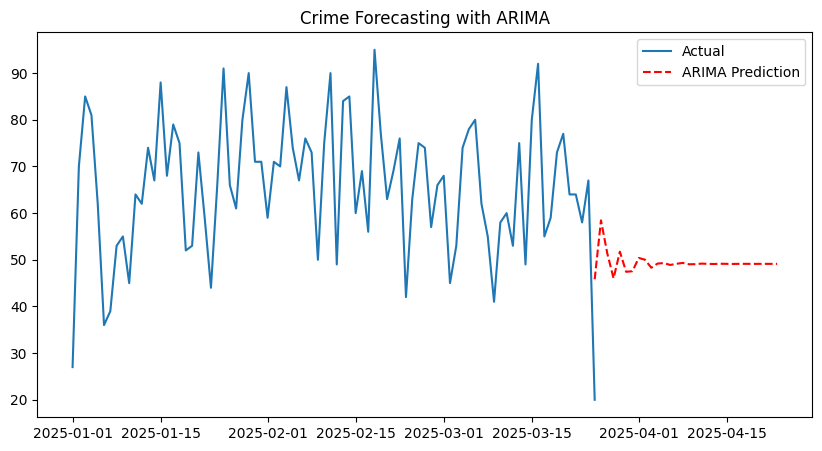

Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.3389
Epoch 2/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1132 
Epoch 3/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0513 
Epoch 4/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0396 
Epoch 5/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0438 
Epoch 6/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0459 
Epoch 7/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0449 
Epoch 8/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0420 
Epoch 9/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0397 
Epoch 10/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0483 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step


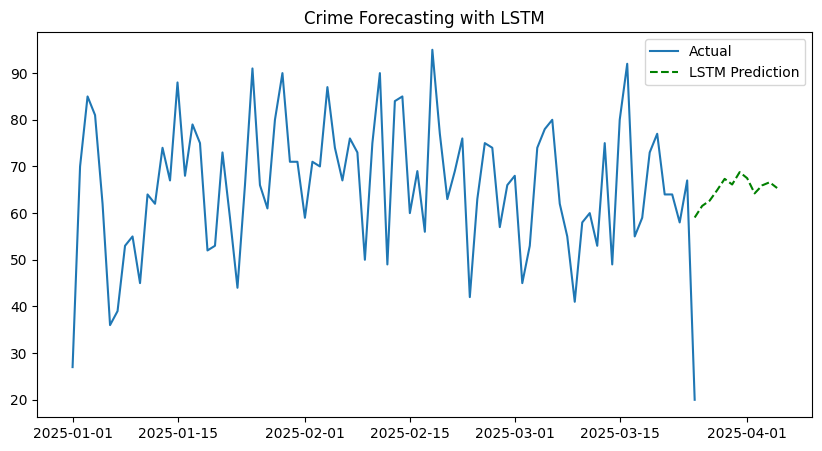

In [ ]:
import pandas as pd
import numpy as np
import geopandas as gpd
import seaborn as sns
import matplotlib.pyplot as plt
import contextily as ctx
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# 📂 Load Data
file_path = "/content/drive/MyDrive/int 375/CRIME INCIDENTS DOT FILES/Crime_Incidents_in_2025.csv"
df = pd.read_csv(file_path)

# ==============================
# 🛠️ STEP 1: DATA PREPROCESSING
# ==============================

# Convert time column to datetime
df['DATE'] = pd.to_datetime(df['REPORT_DAT'], errors='coerce')

# Remove rows with missing coordinates
df = df.dropna(subset=['LATITUDE', 'LONGITUDE'])

# Convert to GeoDataFrame
gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df['LONGITUDE'], df['LATITUDE']), crs="EPSG:4326")
gdf = gdf.to_crs(epsg=3857)  # Convert to Web Mercator

# Encode crime types
encoder = LabelEncoder()
df['CRIME_TYPE_ENCODED'] = encoder.fit_transform(df['OFFENSE'])

# Extract time features
df['HOUR'] = df['DATE'].dt.hour
df['DAY_OF_WEEK'] = df['DATE'].dt.dayofweek
df['MONTH'] = df['DATE'].dt.month

# =========================================================
# 🔥 STEP 2: TIME SERIES FORECASTING (ARIMA + LSTM)
# =========================================================

# Aggregate crimes per day
time_series = df.groupby(df['DATE'].dt.date).size()

# 📌 ARIMA Model
def predict_arima(series):
    model = ARIMA(series, order=(5,1,0))
    arima_result = model.fit()
    future = arima_result.forecast(steps=30)  # Predict next 30 days
    return future

future_crime_arima = predict_arima(time_series)
plt.figure(figsize=(10,5))
plt.plot(time_series, label="Actual")
plt.plot(pd.date_range(start=time_series.index[-1], periods=30, freq='D'), future_crime_arima, label="ARIMA Prediction", linestyle="dashed", color="red")
plt.legend()
plt.title("Crime Forecasting with ARIMA")
plt.show()

# 📌 LSTM Deep Learning Model
def lstm_forecasting(series):
    series = np.array(series).reshape(-1, 1)
    train_size = int(len(series) * 0.8)
    train, test = series[:train_size], series[train_size:]

    # Scale Data
    from sklearn.preprocessing import MinMaxScaler
    scaler = MinMaxScaler()
    train = scaler.fit_transform(train)
    test = scaler.transform(test)

    # Create sequences
    def create_sequences(data, seq_length=5):
        X, y = [], []
        for i in range(len(data) - seq_length):
            X.append(data[i:i+seq_length])
            y.append(data[i+seq_length])
        return np.array(X), np.array(y)

    X_train, y_train = create_sequences(train)
    X_test, y_test = create_sequences(test)

    # Build LSTM Model
    model = Sequential([
        LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], 1)),
        LSTM(50),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse')
    model.fit(X_train, y_train, epochs=10, batch_size=8, verbose=1)

    predictions = model.predict(X_test)
    predictions = scaler.inverse_transform(predictions)

    return predictions

lstm_predictions = lstm_forecasting(time_series)
plt.figure(figsize=(10,5))
plt.plot(time_series, label="Actual")
plt.plot(pd.date_range(start=time_series.index[-1], periods=len(lstm_predictions), freq='D'), lstm_predictions, label="LSTM Prediction", linestyle="dashed", color="green")
plt.legend()
plt.title("Crime Forecasting with LSTM")
plt.show()

In [20]:
!pip install keplergl

In [19]:
!pip install folium

In [21]:
# ===============================
# 📌 STEP 1: IMPORT LIBRARIES
# ===============================
import pandas as pd
import geopandas as gpd
import folium
from folium.plugins import HeatMap
from folium.plugins import MarkerCluster
from keplergl import KeplerGl
from google.colab import output
from IPython.display import display, IFrame
import os

# ===============================
# 📂 STEP 2: LOAD & CLEAN DATA
# ===============================

# Load dataset (Update the path if needed)
file_path = "/content/drive/MyDrive/int 375/CRIME INCIDENTS DOT FILES/Crime_Incidents_in_2025.csv"
df = pd.read_csv(file_path)

# Ensure column names are uppercase
df = df.rename(columns=str.upper)

# Remove rows with missing coordinates & ensure numerical type
df = df.dropna(subset=['LATITUDE', 'LONGITUDE'])
df['LATITUDE'] = pd.to_numeric(df['LATITUDE'], errors='coerce')
df['LONGITUDE'] = pd.to_numeric(df['LONGITUDE'], errors='coerce')

# Convert to GeoDataFrame
gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df['LONGITUDE'], df['LATITUDE']), crs="EPSG:4326")

# ===============================
# 🔥 STEP 4: 3D CRIME VISUALIZATION (KEPLER.GL)
# ===============================

# Ensure Kepler.gl JSON Compliance
df_kepler = df[['LATITUDE', 'LONGITUDE', 'OFFENSE']].dropna()

# Create Kepler.gl Map
map_3d = KeplerGl(height=800)
map_3d.add_data(data=df_kepler, name="Crime Data")

# Display Kepler.gl Map inline
output.enable_custom_widget_manager()
display(map_3d)

print("✅ 3D Crime Visualization (Kepler.gl) Displayed in Colab")

User Guide: https://docs.kepler.gl/docs/keplergl-jupyter


KeplerGl(data={'Crime Data': {'index': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, …

✅ 3D Crime Visualization (Kepler.gl) Displayed in Colab


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


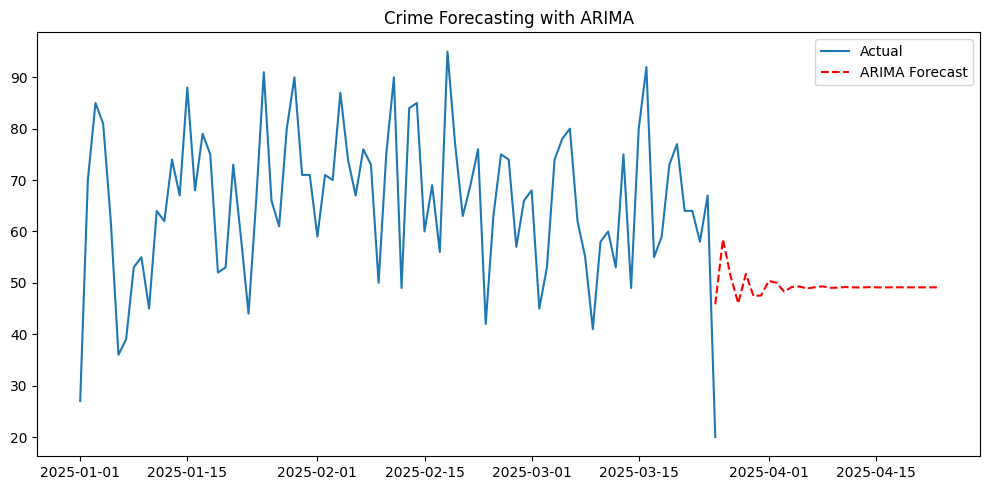

Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.3263
Epoch 2/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.1574 
Epoch 3/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0612 
Epoch 4/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0741 
Epoch 5/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0379 
Epoch 6/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0430 
Epoch 7/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0334 
Epoch 8/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0538 
Epoch 9/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0442 
Epoch 10/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0365 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step


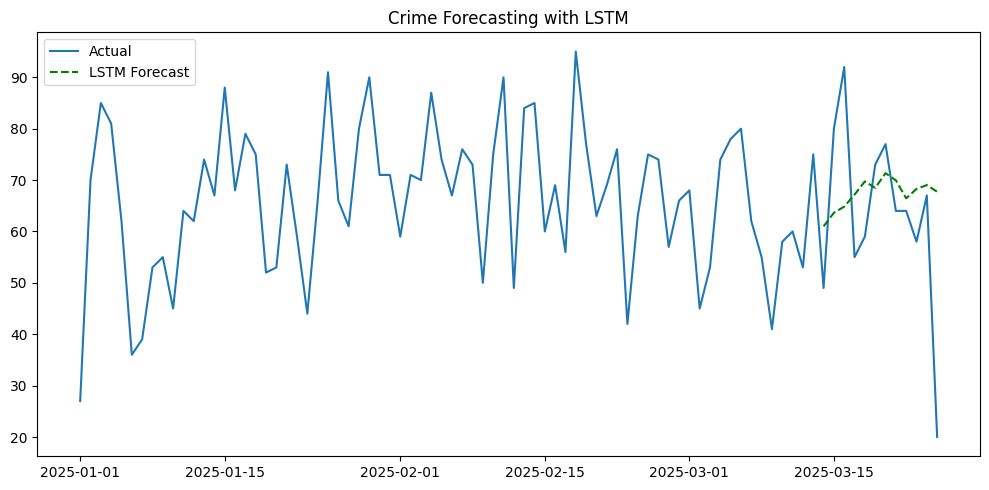

In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from statsmodels.tsa.arima.model import ARIMA

# 📂 Load your dataset
file_path = "/content/drive/MyDrive/int 375/CRIME INCIDENTS DOT FILES/Crime_Incidents_in_2025.csv"
df = pd.read_csv(file_path)

# 🕒 Parse dates
df['DATE'] = pd.to_datetime(df['REPORT_DAT'], errors='coerce')

# 🧼 Clean missing locations
df = df.dropna(subset=['LATITUDE', 'LONGITUDE'])

# 📊 Create daily time series of crime counts
time_series = df.groupby(df['DATE'].dt.date).size()
time_series.index = pd.to_datetime(time_series.index)

# ============================
# 🔮 ARIMA Forecasting
# ============================
def predict_arima(series):
    model = ARIMA(series, order=(5, 1, 0))
    results = model.fit()
    forecast = results.forecast(steps=30)
    return forecast

future_crime_arima = predict_arima(time_series)

# 📈 Plot ARIMA results
plt.figure(figsize=(10,5))
plt.plot(time_series, label="Actual")
plt.plot(pd.date_range(start=time_series.index[-1], periods=30, freq='D'), future_crime_arima, label="ARIMA Forecast", linestyle="dashed", color="red")
plt.title("Crime Forecasting with ARIMA")
plt.legend()
plt.tight_layout()
plt.show()

# ============================
# 🧠 LSTM Forecasting
# ============================
def lstm_forecasting(series):
    data = np.array(series).reshape(-1, 1)

    # Train/test split
    train_size = int(len(data) * 0.8)
    train, test = data[:train_size], data[train_size:]

    # Normalize
    scaler = MinMaxScaler()
    train_scaled = scaler.fit_transform(train)
    test_scaled = scaler.transform(test)

    # Sequence builder
    def create_sequences(data, seq_len=5):
        X, y = [], []
        for i in range(len(data) - seq_len):
            X.append(data[i:i+seq_len])
            y.append(data[i+seq_len])
        return np.array(X), np.array(y)

    X_train, y_train = create_sequences(train_scaled)
    X_test, y_test = create_sequences(test_scaled)

    # Model
    model = Sequential([
        LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], 1)),
        LSTM(50),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse')
    model.fit(X_train, y_train, epochs=10, batch_size=8, verbose=1)

    predictions_scaled = model.predict(X_test)
    predictions = scaler.inverse_transform(predictions_scaled)

    return predictions.flatten(), test[len(test) - len(predictions):].flatten()

lstm_predictions, lstm_actual = lstm_forecasting(time_series)

# 📈 Plot LSTM results
plt.figure(figsize=(10,5))
plt.plot(time_series, label="Actual")
plt.plot(pd.date_range(start=time_series.index[-len(lstm_predictions)], periods=len(lstm_predictions), freq='D'),
         lstm_predictions, label="LSTM Forecast", linestyle="dashed", color="green")
plt.title("Crime Forecasting with LSTM")
plt.legend()
plt.tight_layout()
plt.show()


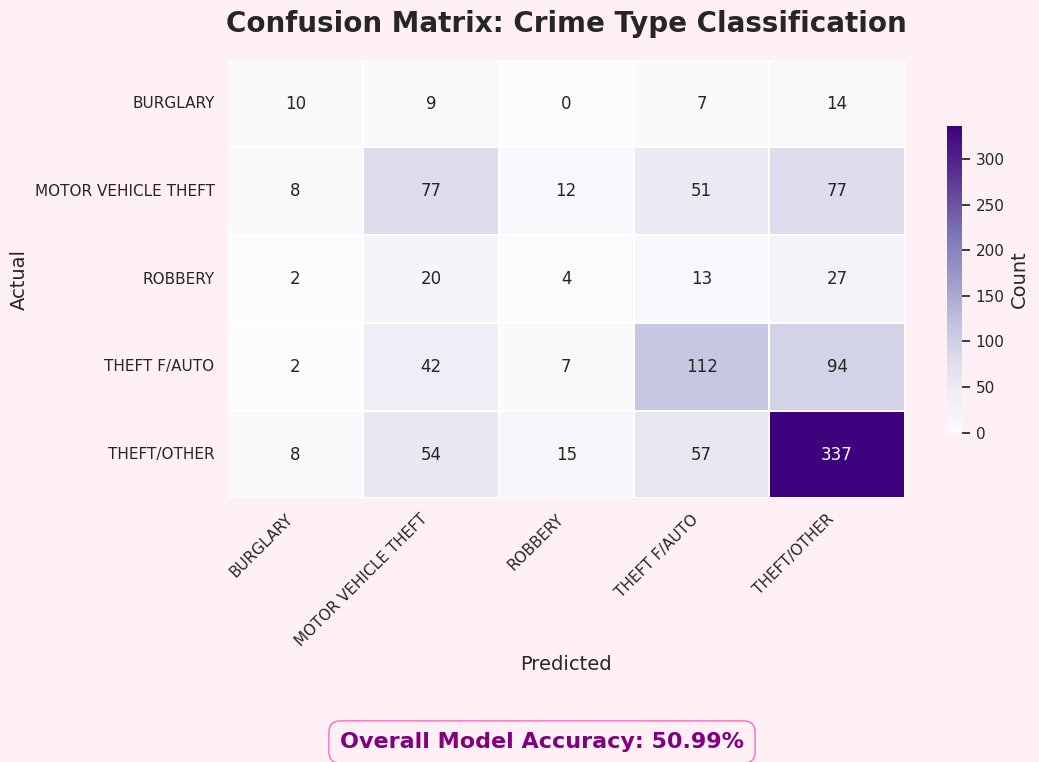

In [28]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score

# 📂 Load and prepare data (modify path if needed)
file_path = "/content/drive/MyDrive/int 375/CRIME INCIDENTS DOT FILES/Crime_Incidents_in_2025.csv"
df = pd.read_csv(file_path)

# 🧹 Basic cleaning
df = df.dropna(subset=['OFFENSE', 'LATITUDE', 'LONGITUDE'])
df['CRIME_TYPE'] = df['OFFENSE'].astype(str)

# 🏆 Focus on top 5 crimes only
top_crimes = df['CRIME_TYPE'].value_counts().nlargest(5).index
filtered_df = df[df['CRIME_TYPE'].isin(top_crimes)]

# 🧠 Encode crime types
encoder = LabelEncoder()
filtered_df = filtered_df.copy()
filtered_df['CRIME_ENCODED'] = encoder.fit_transform(filtered_df['CRIME_TYPE'])

filtered_class_names = list(encoder.classes_)

# 🎯 Features (you can expand with time features too)
X = filtered_df[['LATITUDE', 'LONGITUDE']]
y = filtered_df['CRIME_ENCODED']

# 🔀 Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 🌲 Train classifier
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

# 🎨 Painting your confusion matrix masterpiece...
cm = confusion_matrix(y_test, y_pred)

# 💖 Pastel Cutie Theme Setup
sns.set(style="white", context="notebook")
plt.rcParams.update({
    "axes.facecolor": "#ffe6f0",      # Soft pink background
    "figure.facecolor": "#fff0f5",    # Blush lavender canvas
    "axes.titlesize": 20,
    "axes.labelsize": 14,
    "xtick.labelsize": 11,
    "ytick.labelsize": 11,
    "axes.titleweight": "bold",
})

# 💕 Plot the pastel pretty matrix
plt.figure(figsize=(11, 7))
ax = sns.heatmap(
    cm,
    annot=True,
    fmt='d',
    cmap='Purples',
    xticklabels=filtered_class_names,
    yticklabels=filtered_class_names,
    linewidths=1.3,
    linecolor='white',
    cbar_kws={'label': 'Count', 'shrink': 0.7}
)

plt.title("Confusion Matrix: Crime Type Classification", pad=20)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)

# 💖 Add accuracy like it's a signed designer label
model_accuracy = accuracy_score(y_test, y_pred)
plt.figtext(
    0.5, -0.08,
    f"Overall Model Accuracy: {model_accuracy:.2%}",
    ha='center',
    fontsize=16,
    fontweight='bold',
    color='purple',
    bbox=dict(facecolor='#fff0f5', edgecolor='hotpink', boxstyle='round,pad=0.5')
)

plt.tight_layout()
plt.show()


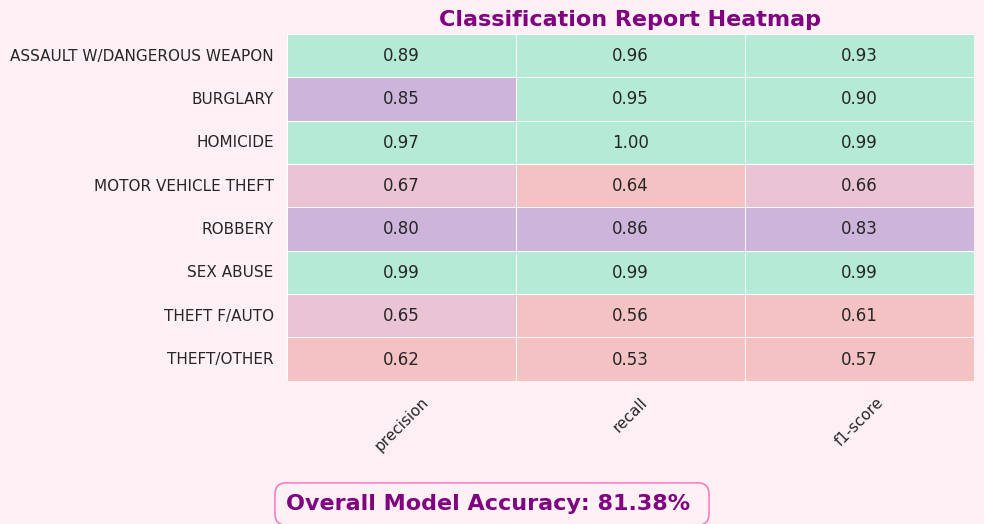

In [ ]:
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# 🧁 Get the report as a dictionary
report_dict = classification_report(
    y_test,
    y_pred,
    labels=filtered_classes,
    target_names=filtered_class_names,
    output_dict=True,
    zero_division=0
)
report_df = pd.DataFrame(report_dict).transpose()

# 🌸 Drop support & summary rows for a clean visual
report_df_vis = report_df.drop(columns=['support'], errors='ignore').drop(index=['accuracy', 'macro avg', 'weighted avg'], errors='ignore')

# 💗 Plot the pastel heatmap
plt.figure(figsize=(10, len(report_df_vis)*0.6))
sns.heatmap(
    report_df_vis,
    annot=True,
    fmt=".2f",
    cmap=sns.color_palette(["#f4c2c2", "#eac4d5", "#cdb4db", "#b5ead7"], as_cmap=True),
    cbar=False,
    linewidths=0.5,
    linecolor='white'
)

plt.title("Classification Report Heatmap", color='purple', fontsize=16, weight='bold')
plt.yticks(ticks=[i + 0.5 for i in range(len(filtered_class_names))], labels=filtered_class_names, rotation=0)
plt.xticks(rotation=45)

# ✨ Add model accuracy as a fab lil badge
model_accuracy = report_dict.get("accuracy", None)
if model_accuracy is not None:
    plt.figtext(
        0.5, -0.08,
        f"Overall Model Accuracy: {model_accuracy:.2%} ",
        ha='center',
        fontsize=16,
        fontweight='bold',
        color='purple',
        bbox=dict(facecolor='#fff0f5', edgecolor='hotpink', boxstyle='round,pad=0.5')
    )

plt.tight_layout()
plt.show()


<ipython-input-29-5d362261a2fe>:40: UserWarning: The palette list has more values (3) than needed (2), which may not be intended.
  sns.barplot(data=df_metrics, x="Metric", y="Value", hue="Model", palette=palette)
<ipython-input-29-5d362261a2fe>:46: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


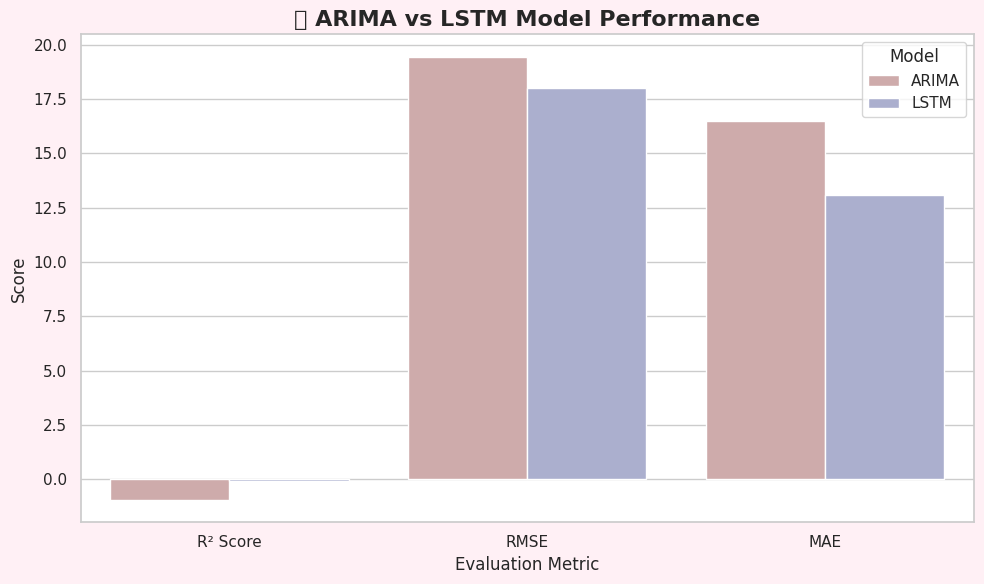

In [29]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# 💡 Make sure actual and predicted values are NumPy arrays
actual_values_arima = time_series[-30:]
predicted_arima = future_crime_arima

actual_values_lstm = time_series[-len(lstm_predictions):]
predicted_lstm = lstm_predictions.flatten()

# 📈 Calculate metrics
metrics = {
    "R² Score": [
        r2_score(actual_values_arima, predicted_arima),
        r2_score(actual_values_lstm, predicted_lstm)
    ],
    "RMSE": [
        np.sqrt(mean_squared_error(actual_values_arima, predicted_arima)),
        np.sqrt(mean_squared_error(actual_values_lstm, predicted_lstm))
    ],
    "MAE": [
        mean_absolute_error(actual_values_arima, predicted_arima),
        mean_absolute_error(actual_values_lstm, predicted_lstm)
    ]
}

# 📊 Prepare DataFrame for seaborn
df_metrics = pd.DataFrame(metrics, index=["ARIMA", "LSTM"]).reset_index().melt(id_vars="index")
df_metrics.columns = ["Model", "Metric", "Value"]

# 🎨 Cute Bar Plot
plt.figure(figsize=(10, 6))
sns.set(style="whitegrid")
palette = ["#d4a5a5", "#a5aad4", "#a5d4bf"]

sns.barplot(data=df_metrics, x="Metric", y="Value", hue="Model", palette=palette)

plt.title("📊 ARIMA vs LSTM Model Performance", fontsize=16, fontweight='bold')
plt.ylabel("Score")
plt.xlabel("Evaluation Metric")
plt.legend(title="Model")
plt.tight_layout()
plt.show()
